In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
df_filtered = pd.read_csv('../data/traffic_df_with_bridges_and_intersections_onlyR.csv')

In [3]:
#Giving bridges same values as connected intersections

df_filtered = df_filtered.reset_index()
column_range = ['Heavy Truck', 'Medium Truck',
       'Small Truck', 'Large Bus', 'Medium Bus', 'Micro Bus', 'Utility', 'Car',
       'Auto Rickshaw', 'Motor Cycle', 'Bi-Cycle', 'Cycle Rickshaw', 'Cart',
       'Motorized', 'Non Motorized', 'Total AADT', '(AADT)']

for i in range(1, len(df_filtered)):
    if df_filtered.loc[i, 'type'] == 'bridge':
        for col in column_range:
            if pd.isnull(df_filtered.loc[i, col]):
                df_filtered.loc[i, col] = df_filtered.loc[i-1, col]

In [4]:
#Creating cargo weight
# Convert columns to numeric, coercing any errors to NaN
df_filtered['Heavy Truck'] = pd.to_numeric(df_filtered['Heavy Truck'], errors='coerce')
df_filtered['Medium Truck'] = pd.to_numeric(df_filtered['Medium Truck'], errors='coerce')
df_filtered['Small Truck'] = pd.to_numeric(df_filtered['Small Truck'], errors='coerce')
df_filtered['Utility'] = pd.to_numeric(df_filtered['Utility'], errors='coerce')
df_filtered['Car'] = pd.to_numeric(df_filtered['Car'], errors='coerce')


# Perform the calculation
df_filtered['cargo_weight'] = (df_filtered['Heavy Truck'] * 19 +
                               df_filtered['Medium Truck'] * 5 +
                               df_filtered['Small Truck'] * 1.5 +
                               df_filtered['Utility'] * 0.97)

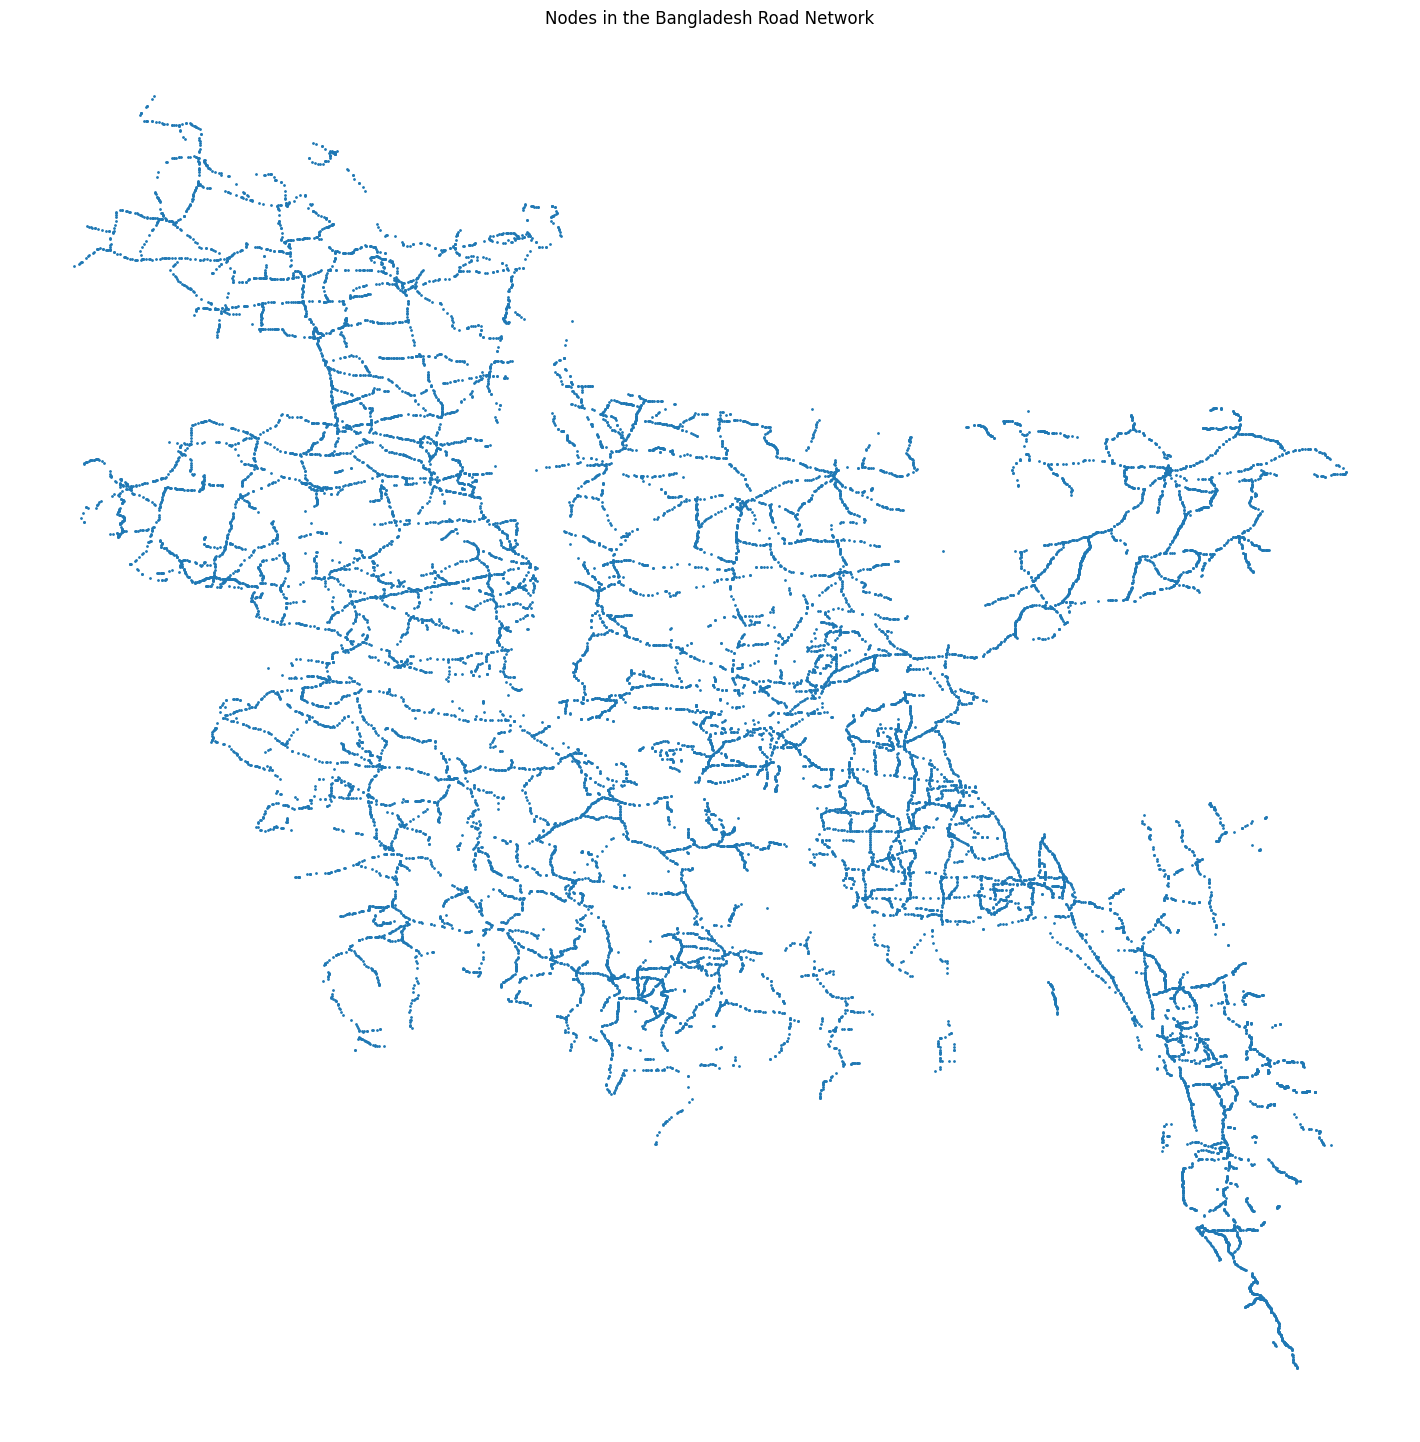

In [5]:
# Assuming combined_df is your DataFrame and it has 'lat' and 'lon' columns
positions = {index: (
    row['lon'], row['lat'], row['Name'], row['Road'], row['base_road'],
    row['Heavy Truck'], row['Medium Truck'], row['Small Truck'],
    row['Large Bus'], row['Medium Bus'], row['Micro Bus'], row['Utility'],
    row['Car'], row['Auto Rickshaw'], row['Motor Cycle'], row['Bi-Cycle'],
    row['Cycle Rickshaw'], row['Cart'], row['Motorized'], row['Non Motorized'],
    row['Total AADT'], row['(AADT)'], row['cargo_weight'], row['condition']
) for index, row in df_filtered.iterrows()}

# Create a graph
G = nx.Graph()

# Add nodes with positions
for node, pos in positions.items():
    G.add_node(node,
               pos=(pos[0], pos[1]),
               Name=pos[2],
               Road=pos[3],
               base_road=pos[4],
               Heavy_Truck=pos[5],
               Medium_Truck=pos[6],
               Small_Truck=pos[7],
               Large_Bus=pos[8],
               Medium_Bus=pos[9],
               Micro_Bus=pos[10],
               Utility=pos[11],
               Car=pos[12],
               Auto_Rickshaw=pos[13],
               Motor_Cycle=pos[14],
               Bi_Cycle=pos[15],
               Cycle_Rickshaw=pos[16],
               Cart=pos[17],
               Motorized=pos[18],
               Non_Motorized=pos[19],
               Total_AADT=pos[20],
               AADT=pos[21],
               Cargo_weight=pos[22],
               condition = pos[23])  # Assuming 'AADT' is at pos[21], adjust accordingly


# If you also want to connect nodes, you can add edges here
# For example, to connect each node to its nearest neighbor (simplistic approach):
# for i, node_i_pos in positions.items():
#     closest_node, min_dist = None, float('inf')
#     for j, node_j_pos in positions.items():
#         if i != j:
#             dist = ((node_i_pos[0] - node_j_pos[0])**2 + (node_i_pos[1] - node_j_pos[1])**2)**0.5
#             if dist < min_dist:
#                 closest_node, min_dist = j, dist
#     G.add_edge(i, closest_node)

# Extract positions from graph nodes for plotting
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(14, 14))
# Draw the graph
nx.draw(G, pos, node_size=1)  # Adjust node_size for better visibility
plt.title('Nodes in the Bangladesh Road Network')
plt.show()

In [6]:
# Iterate through each node and its attributes
for node, attrs in G.nodes(data=True):
    for key, value in attrs.items():
        # Check if the attribute value is 'NS' or NaN (pd.isna() checks for NaN)
        if value == 'NS' or pd.isna(value):
            # Update the attribute value to 0
            attrs[key] = 0

# Now, all 'NS' and NaN values in node attributes are replaced with 0

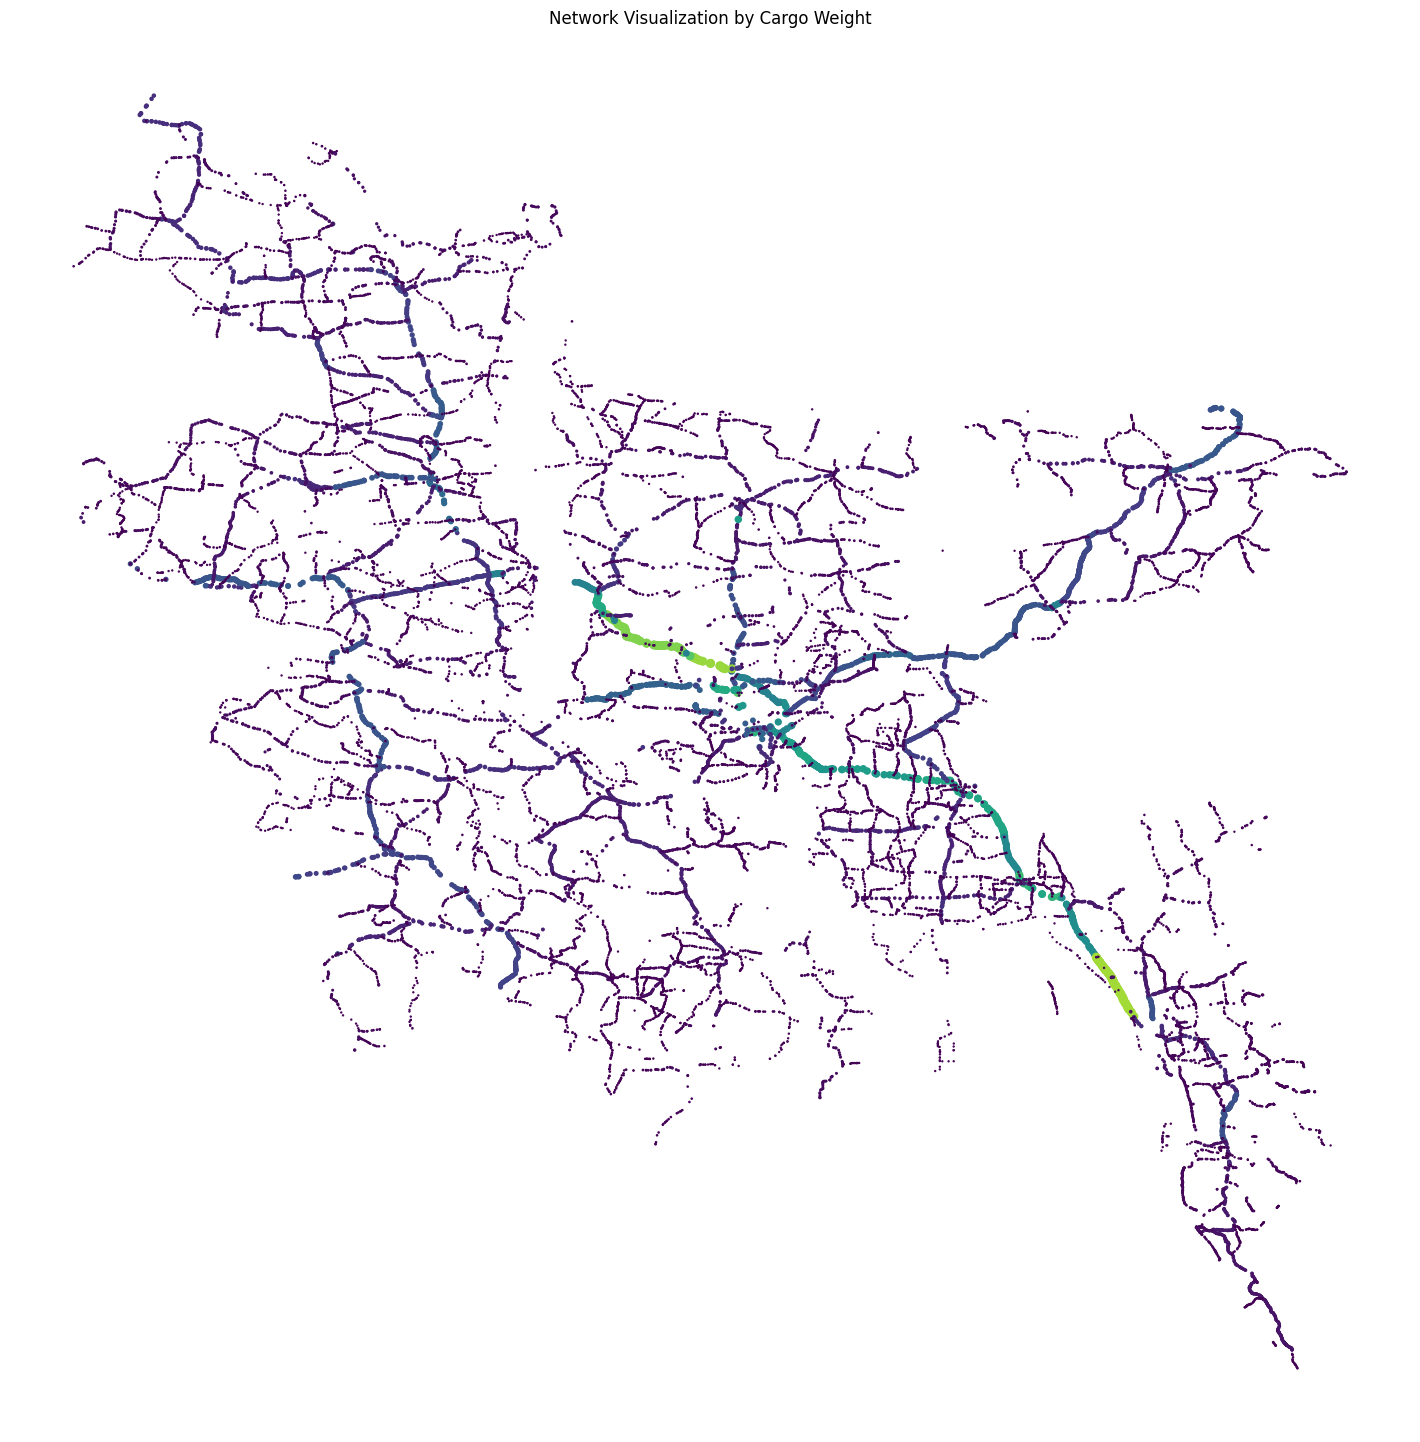

In [9]:
#creating network with cargo_weight causing colours

# Define min and max values for cargo_weight
min_cargo_weight, max_cargo_weight = 0, 60000

# Normalize cargo_weight values for both color and size
cargo_weights = np.array([G.nodes[node]['Cargo_weight'] for node in G.nodes()])
norm_color = mcolors.Normalize(vmin=min_cargo_weight, vmax=max_cargo_weight)
norm_size = mcolors.Normalize(vmin=min_cargo_weight, vmax=max_cargo_weight, clip=True)

# Apply colormap for color mapping
cmap = plt.cm.viridis
node_colors = [cmap(norm_color(weight)) for weight in cargo_weights]

# Calculate node sizes in the range of 0.5 to 20 based on cargo_weight
min_size, max_size = 0.5, 35
node_sizes = [norm_size(weight) * (max_size - min_size) + min_size for weight in cargo_weights]
pos = nx.get_node_attributes(G, 'pos')
# Draw the network
plt.figure(figsize=(14, 14))  # Adjust the figure size as needed
# You might want to define positions with pos. If not, a layout will be automatically chosen
nx.draw(G,pos, node_color=node_colors, node_size=node_sizes, with_labels=False)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_color)
sm.set_array([])
# Customize the colorbar
# cbar = plt.colorbar(sm, label='Cargo Weight')
# cbar.set_label('Cargo Weight', rotation=270, labelpad=15)  # Set the label for the colorbar
# cbar.set_ticks([0, 15000, 30000, 45000, 60000])  # Example ticks for the colorbar
# cbar.set_ticklabels(['0', '26.25k', '52.5k', '78.75k', '105k'])


plt.title('Network Visualization by Cargo Weight')
plt.show()

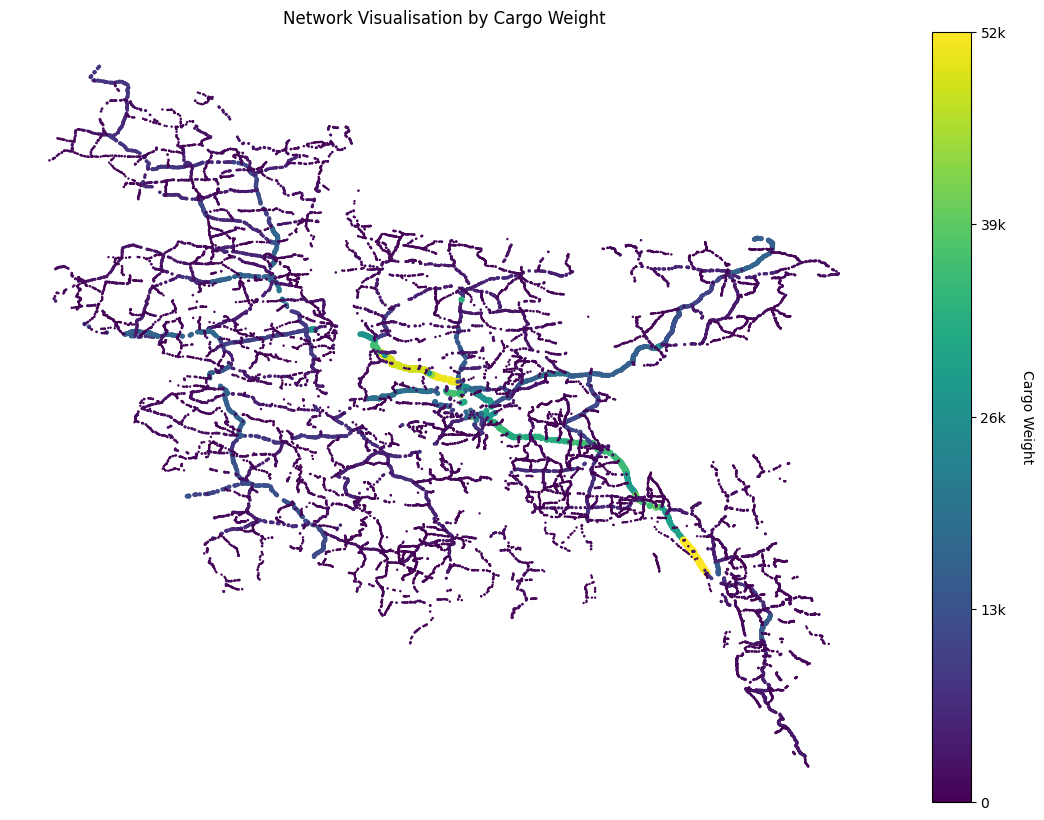

In [8]:
#same map but with a forced legend
# Normalize cargo_weight values for color mapping
cargo_weights = np.array([G.nodes[node]['Cargo_weight'] for node in G.nodes()])
norm = mcolors.Normalize(vmin=0, vmax=52000)
cmap = plt.cm.viridis

# Apply normalization and colormap to cargo_weights for actual node colors
node_colors = [cmap(norm(weight)) for weight in cargo_weights]

# Calculate node sizes in the range of 0.5 to 20 based on cargo_weight
node_sizes = [(norm(weight) * (20 - 0.5) + 0.5) for weight in cargo_weights]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(14, 10))
pos = nx.get_node_attributes(G, 'pos')
# Draw the network
nx.draw(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes, with_labels=False)

# Create a ScalarMappable for the colorbar, making sure it knows about the colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the colorbar to the plot, linked to the specified axes
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Cargo Weight', rotation=270, labelpad=20)
cbar.set_ticks([0, 13000, 26000, 39000, 52000])
cbar.set_ticklabels(['0', '13k', '26k', '39k', '52k'])

plt.title('Network Visualisation by Cargo Weight')
plt.show()

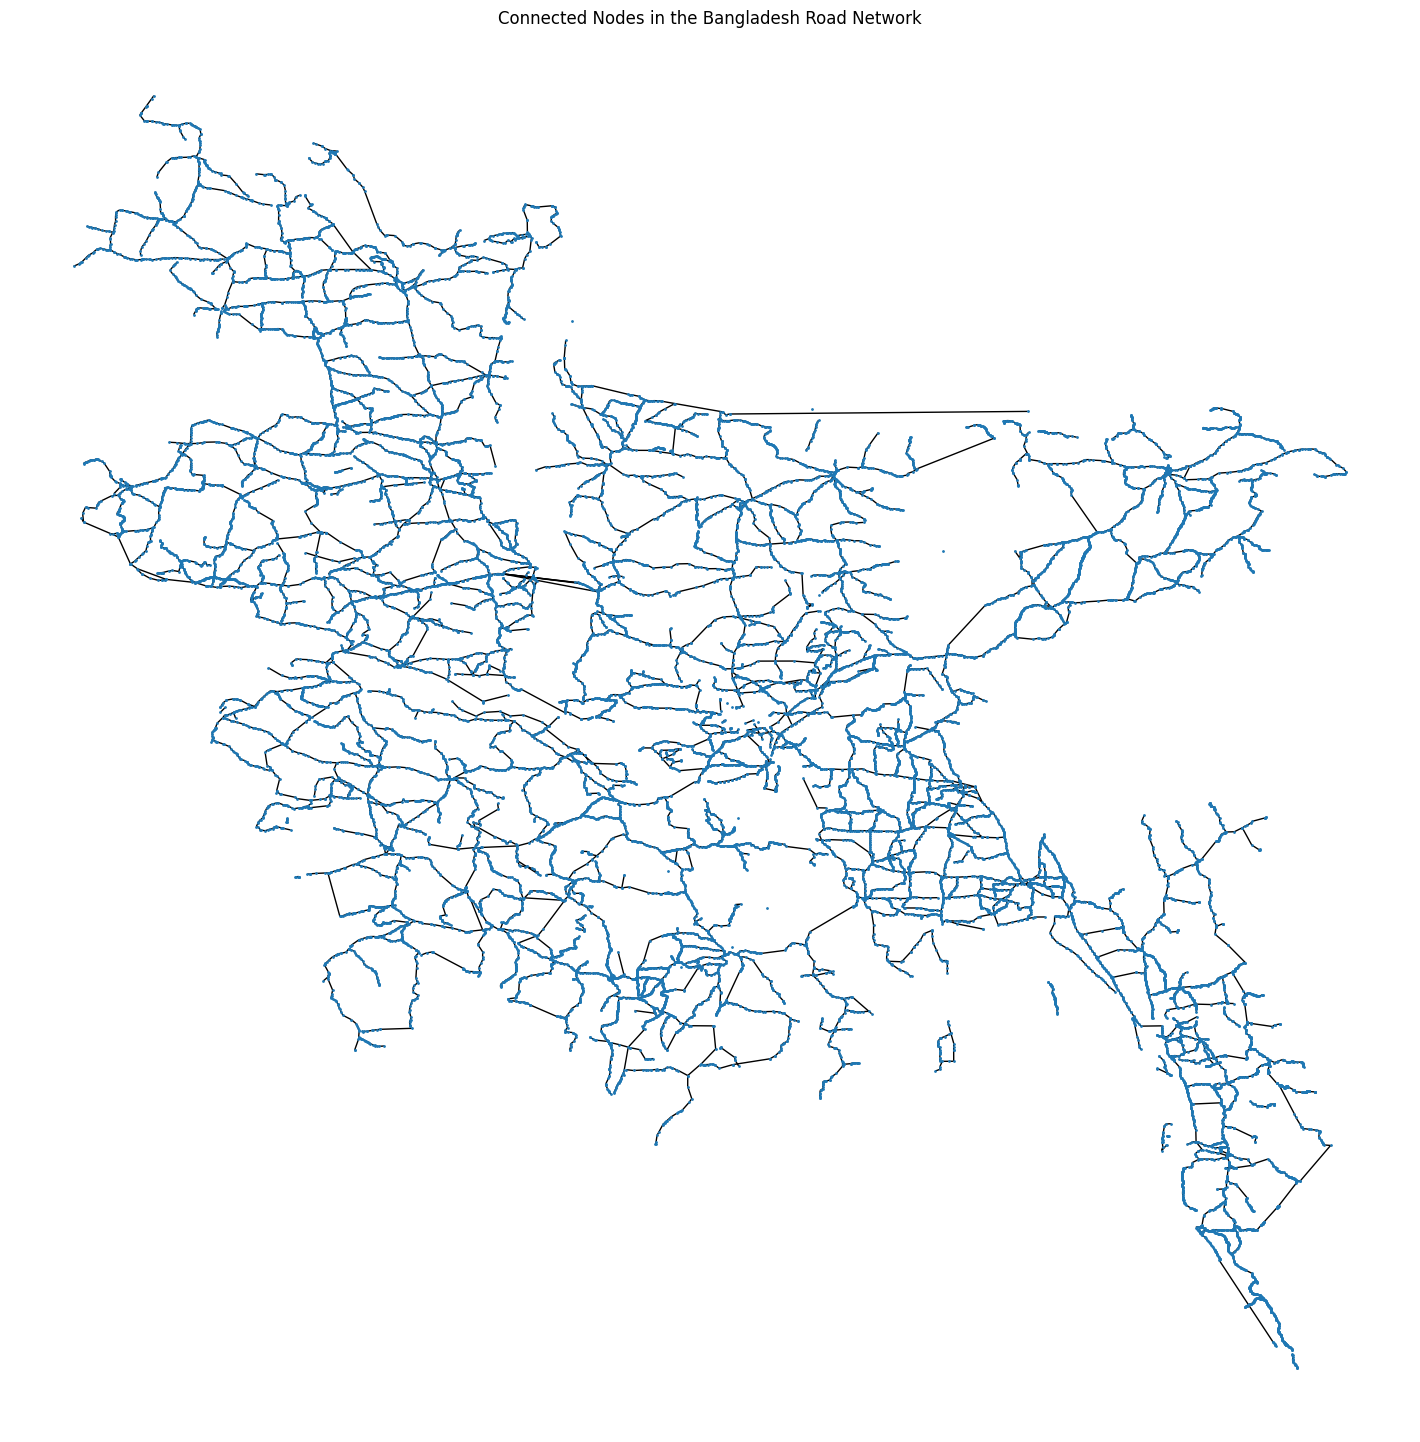

In [10]:
#adding edges
previous_node = None
previous_base_road = None

for index, row in df_filtered.iterrows():
    current_base_road = row['base_road']
  
    if previous_node is not None and previous_base_road == current_base_road:
        G.add_edge(previous_node, index)
    
    previous_node = index
    previous_base_road = current_base_road
    
for index, row in df_filtered.iterrows():
    row_lat = row['lat']
    row_lon = row['lon']
    best_abs = 9999
    best_row = None
    # Check if the value is not NaN and is an instance of list
    if isinstance(row['identified_roads'], list):
        for road in row['identified_roads']:
            for index2, row2 in df_filtered[df_filtered['base_road'] == road].iterrows():
                diff_lat = abs(row2['lat'] - row_lat)
                diff_lon = abs(row2['lon'] - row_lon)
                diff_abs = diff_lon + diff_lat
                if diff_abs < best_abs:
                    best_abs = diff_abs
                    best_row = row2
    if best_row is not None:
        G.add_edge(best_row.name, row.name, weight=0)
        
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(14, 14))
# Draw the graph
nx.draw(G, pos, node_size=1)  # Adjust node_size for better visibility
plt.title('Connected Nodes in the Bangladesh Road Network')
plt.show()

In [11]:
#getting a df based on cargo_weight
df_filtered_unique = df_filtered[df_filtered['type'] == 'road'].drop_duplicates(subset=['cargo_weight'])
df_filtered_unique[['base_road', 'Name', 'cargo_weight']].sort_values(by='cargo_weight', ascending=False)

,base_road,Name,cargo_weight
251,N1,Baroirdala Z1086- Barabkunda Z1087 (Right),51696.59
2329,N4,Joydebpur-Kadda(Int.with N105),50690.23
2353,N4,Kaliakoir (Int.with R315)-Gorai(Int.with Z4011),48629.82
0,N1,Jatrabari - Int.with Z1101 (Left) (Right),46111.60
2301,N302,Abdullahpur-Rana Bhola (Int.with R303),44776.52
...,...,...,...
19049,Z6855,Bagshara-Chabbis Nagar (int.with Z6809),5.00
21889,Z8704,Nabagram(Int.with Z8037)-Ekshirapur,3.97
18618,Z6032,Hamkuria-Taras,1.50
10735,Z1084,Muhuriganj-Int.with Z1025,0.00


In [12]:
#Cargo weight with condition D
df_filtered_unique = df_filtered[df_filtered['condition'] == 'D']
df_filtered_unique[['base_road', 'Name', 'cargo_weight']].sort_values(by='cargo_weight', ascending=False)

,base_road,Name,cargo_weight
292,N1,Baro Aulia,51696.59
295,N1,Modonhat Bridge,51696.59
2305,N302,ASHULIA RCC GIDER BRIDGE,36571.56
2704,N5,MOHADEVPUR RCC GIDER BRIDGE,18965.83
2699,N5,PUKHURIA RCC GIDER BRIDGE,18965.83
...,...,...,...
21871,Z8704,.,NaN
21873,Z8704,NaN,NaN
21881,Z8704,NaN,NaN
21885,Z8704,.,NaN
